# Localization

Predict a single bounding box per image. Uses the MobileNet-based classifier as the starting point.

**NOTE:** The results in this notebook are similar to those shown in the book but are not 100% the same. Because neural networks are initialized with random numbers, each training session will give slightly different results.

## Load the annotations

In [1]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_dir = "snacks"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [3]:
train_annotations = pd.read_csv(os.path.join(data_dir, "annotations-train.csv"))
train_annotations.head()

,image_id,x_min,x_max,y_min,y_max,class_name,folder
0,009218ad38ab2010,0.192620,0.729831,0.127606,0.662219,cake,cake
1,009218ad38ab2010,0.802377,1.000000,0.102585,0.405338,ice cream,cake
2,009218ad38ab2010,0.814884,0.970607,0.121768,0.357798,ice cream,cake
3,00c7515143b32051,0.135084,0.904315,0.081735,0.909091,cake,muffin
4,00c7515143b32051,0.155722,0.910569,0.083403,0.893244,muffin,muffin


In [4]:
len(train_annotations)

7040

In [5]:
val_annotations = pd.read_csv(os.path.join(data_dir, "annotations-val.csv"))
test_annotations = pd.read_csv(os.path.join(data_dir, "annotations-test.csv"))

In [6]:
len(val_annotations), len(test_annotations)

(1417, 1380)

## Plot training image + its bounding boxes

In [7]:
image_width = 224
image_height = 224

In [8]:
from helpers import plot_image

Using TensorFlow backend.


In [9]:
from keras.preprocessing import image

def plot_image_from_row(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox = (row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"])
    plot_image(img, [bbox])

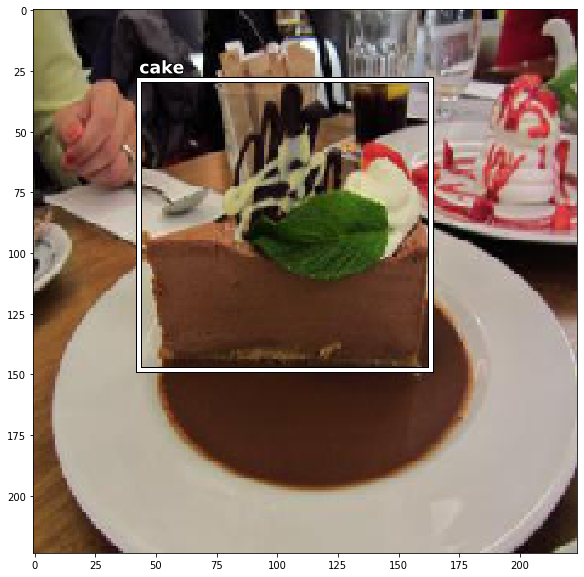

In [10]:
plot_image_from_row(train_annotations.iloc[0], train_dir)

## Custom generator

In [11]:
from helpers import BoundingBoxGenerator

In [12]:
batch_size = 32
train_generator = BoundingBoxGenerator(train_annotations, train_dir, 
                                       image_height, image_width, 
                                       batch_size, shuffle=True)

In [25]:
train_iter = iter(train_generator)
X, (y_class, y_bbox) = next(train_iter)

In [26]:
X.shape, y_class.shape, y_bbox.shape

((32, 224, 224, 3), (32,), (32, 4))

In [27]:
y_bbox

array([[2.91627e-01, 3.66886e-01, 4.21513e-01, 5.19700e-01],
       [1.08193e-01, 7.50469e-01, 3.60225e-01, 8.86179e-01],
       [2.08255e-01, 9.95622e-01, 2.50200e-03, 9.90826e-01],
       [6.25000e-04, 9.98124e-01, 7.50600e-03, 9.98332e-01],
       [6.46002e-01, 9.02965e-01, 2.95184e-01, 8.76798e-01],
       [1.14112e-01, 9.01038e-01, 3.22290e-02, 9.23074e-01],
       [0.00000e+00, 5.75373e-01, 9.60840e-02, 2.07338e-01],
       [4.94059e-01, 8.18011e-01, 5.01873e-01, 9.86891e-01],
       [2.73296e-01, 5.23452e-01, 4.51209e-01, 7.97331e-01],
       [4.95935e-01, 7.33584e-01, 4.82068e-01, 6.97248e-01],
       [2.55159e-01, 7.63602e-01, 4.52500e-01, 7.28125e-01],
       [0.00000e+00, 9.99375e-01, 2.00170e-02, 1.00000e+00],
       [2.32406e-01, 7.57774e-01, 5.22095e-01, 9.72177e-01],
       [6.12688e-01, 9.89983e-01, 3.77972e-01, 7.17146e-01],
       [2.64476e-01, 7.54304e-01, 1.92488e-01, 7.76995e-01],
       [0.00000e+00, 4.15609e-01, 1.53575e-01, 8.83250e-01],
       [4.64167e-01, 7.6

In [28]:
y_class

array([17, 18,  8,  4, 10,  2, 17, 17,  3,  5, 11, 18, 12, 11, 15, 10,  6,
        4,  2, 17,  2, 15, 19,  1, 11, 17, 18, 19, 10, 17,  2,  4])

In [29]:
from helpers import labels
list(map(lambda x: labels[x], y_class))

['strawberry',
 'waffle',
 'hot dog',
 'carrot',
 'juice',
 'cake',
 'strawberry',
 'strawberry',
 'candy',
 'cookie',
 'muffin',
 'waffle',
 'orange',
 'muffin',
 'pretzel',
 'juice',
 'doughnut',
 'carrot',
 'cake',
 'strawberry',
 'cake',
 'pretzel',
 'watermelon',
 'banana',
 'muffin',
 'strawberry',
 'waffle',
 'watermelon',
 'juice',
 'strawberry',
 'cake',
 'carrot']

In [30]:
len(train_generator)

220

In [31]:
def plot_image_from_batch(X, y_class, y_bbox, img_idx):
    class_name = labels[y_class[img_idx]]
    bbox = y_bbox[img_idx]
    plot_image(X[img_idx], [[*bbox, class_name]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


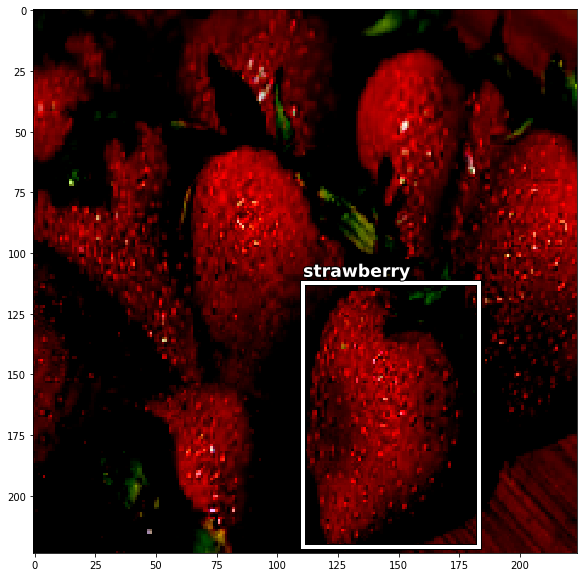

In [38]:
plot_image_from_batch(X, y_class, y_bbox, 7)

In [39]:
X, (y_class, y_bbox) = next(train_iter)

## Load the best model from last time

In [43]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.models import Model, load_model
from keras import optimizers, callbacks
import keras.backend as K

classifier_model = load_model("checkpoints/multisnacks-0.7162-0.8419.hdf5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [44]:
classifier_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                20500     
_________________________________________________________________
activation_3 (Activation)    (None, 20)                0         
Total params: 3,249,364
Trainable params: 3,227,476
Non-trainable params: 21,888
_________________________________________________________________


## Add the bounding box predictor to the model

In [67]:
num_classes = 20

# The MobileNet feature extractor is the first "layer".
base_model = classifier_model.layers[0]

# Add a global average pooling layer after MobileNet.
pool = GlobalAveragePooling2D()(base_model.outputs[0])

# Reconstruct the classifier layers.
clf = Dropout(0.7)(pool)
clf = Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), name="dense_class")(clf)
clf = Activation("softmax", name="class_prediction")(clf)

# Add new layers for the bounding box predictor.
bbox = Conv2D(512, 3, padding="same")(base_model.outputs[0])
bbox = BatchNormalization()(bbox)
bbox = Activation("relu")(bbox)
bbox = GlobalAveragePooling2D()(bbox)
bbox = Dense(4, name="bbox_prediction")(bbox)

# Create the new model.
model = Model(inputs=base_model.inputs, outputs=[clf, bbox])

In [68]:
for layer in base_model.layers:
    layer.trainable = False

In [69]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [70]:
from keras.utils import plot_model
plot_model(model, to_file="bbox_model.png")

Put the old weights back, or the classifier won't work anymore:

In [71]:
layer_dict = {layer.name:i for i, layer in enumerate(model.layers)}

# Get the weights from the checkpoint model.
weights, biases = classifier_model.layers[-2].get_weights()

# Put them into the new model.
model.layers[layer_dict["dense_class"]].set_weights([weights, biases])

In [72]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy" })

## Try the model on an image

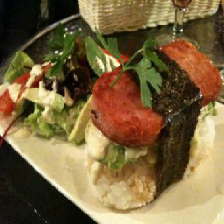

In [51]:
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image

img = image.load_img(train_dir + "/salad/2ad03070c5900aac.jpg", target_size=(image_width, image_height))
img

In [52]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [53]:
preds = model.predict(x)
preds

[array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
         2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
         6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
         1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
         9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
       dtype=float32),
 array([[-0.04342733,  2.7566466 , -1.5830104 ,  0.6947104 ]],
       dtype=float32)]

In [54]:
len(preds)

2

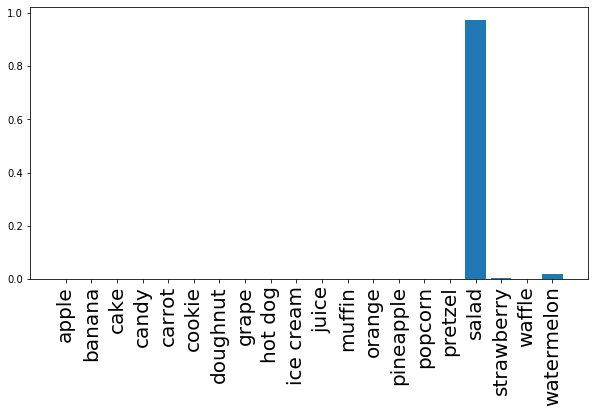

In [55]:
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), preds[0].squeeze())
plt.xticks(range(num_classes), labels, rotation=90, fontsize=20)
plt.show()

In [56]:
preds = classifier_model.predict(x)
preds

array([[5.5659082e-05, 7.1897813e-07, 7.4317250e-05, 4.5375164e-06,
        2.9821682e-04, 2.9114778e-06, 5.2616288e-06, 4.8986397e-04,
        6.5828249e-04, 6.8758155e-04, 3.6887937e-05, 6.2949434e-06,
        1.6075590e-05, 2.1348683e-04, 1.9503818e-06, 8.5053324e-07,
        9.7398055e-01, 2.2265238e-03, 1.5832029e-03, 1.9656979e-02]],
      dtype=float32)

In [57]:
preds = model.predict_generator(train_generator)

In [58]:
preds[1].shape

(7040, 4)

## Train the model

In [59]:
val_generator = BoundingBoxGenerator(val_annotations, val_dir, 
                                     image_height, image_width, 
                                     batch_size, shuffle=False)

In [60]:
from helpers import combine_histories, plot_loss, plot_bbox_loss

In [61]:
histories = []

In [62]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 11s 48ms/step - loss: 2.1854 - class_prediction_loss: 0.4623 - bbox_prediction_loss: 0.1575 - class_prediction_acc: 0.8730 - val_loss: 1.2348 - val_class_prediction_loss: 0.6038 - val_bbox_prediction_loss: 0.0483 - val_class_prediction_acc: 0.8089
Epoch 2/5
220/220 [==============================] - 9s 41ms/step - loss: 0.9588 - class_prediction_loss: 0.4356 - bbox_prediction_loss: 0.0375 - class_prediction_acc: 0.8768 - val_loss: 1.2041 - val_class_prediction_loss: 0.5859 - val_bbox_prediction_loss: 0.0469 - val_class_prediction_acc: 0.8260
Epoch 3/5
220/220 [==============================] - 9s 41ms/step - loss: 0.9175 - class_prediction_loss: 0.4298 - bbox_prediction_loss: 0.0337 - class_prediction_acc: 0.8751 - val_loss: 1.1717 - val_class_prediction_loss: 0.5941 - val_bbox_prediction_loss: 0.0426 - val_class_prediction_acc: 0.8246
Epoch 4/5
220/220 [==============================] - 9s 41ms/step - loss: 0.8900 - class_prediction

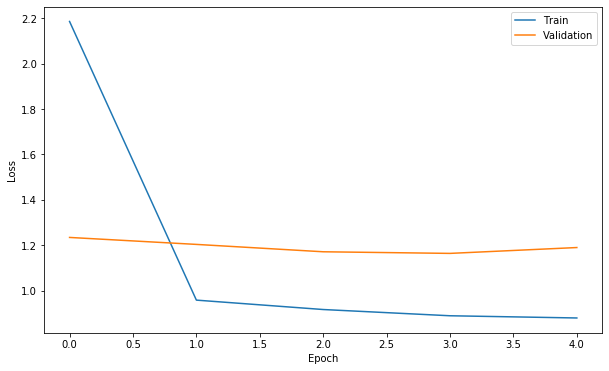

In [63]:
history = combine_histories(histories)
plot_loss(history)

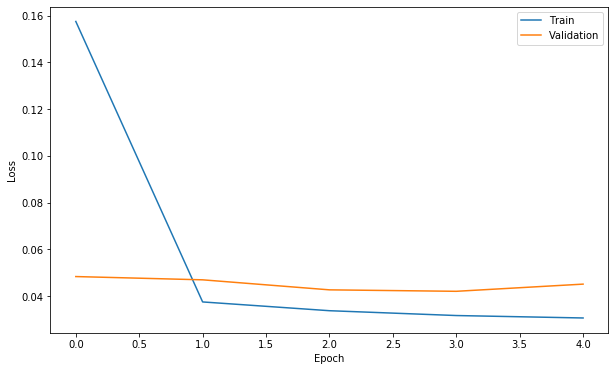

In [64]:
plot_bbox_loss(history)

## Adding the IOU metric

In [65]:
from helpers import iou, MeanIOU, plot_iou

bbox1 = [0.2, 0.7, 0.3, 0.6, "bbox1"]
bbox2 = [0.4, 0.6, 0.2, 0.5, "bbox2"]
iou(bbox1, bbox2)

0.23529411764705882

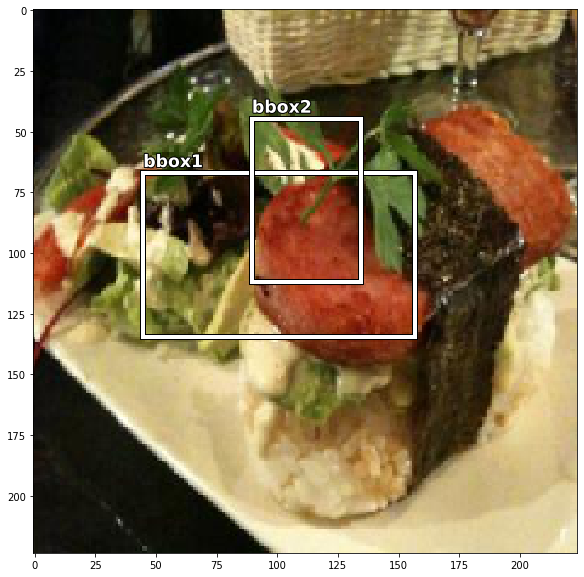

In [66]:
plot_image(img, [bbox1, bbox2])

**NOTE:** At this point I went back to the beginning of the notebook and created the model again. That way you can see clearer how the mean IOU increases over time. Just run all the cells from the section **Add the bounding box predictor to the model** again, then come back here. 

In [73]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[1.0, 10.0],
              optimizer=optimizers.Adam(lr=1e-3),
              metrics={ "class_prediction": "accuracy", 
                        "bbox_prediction": MeanIOU().mean_iou })

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [74]:
histories = []

In [75]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 11s 51ms/step - loss: 2.1779 - class_prediction_loss: 0.4598 - bbox_prediction_loss: 0.1569 - class_prediction_acc: 0.8720 - bbox_prediction_mean_iou: 0.2385 - val_loss: 1.2880 - val_class_prediction_loss: 0.6169 - val_bbox_prediction_loss: 0.0523 - val_class_prediction_acc: 0.8153 - val_bbox_prediction_mean_iou: 0.2829
Epoch 2/5
220/220 [==============================] - 10s 44ms/step - loss: 0.9605 - class_prediction_loss: 0.4368 - bbox_prediction_loss: 0.0376 - class_prediction_acc: 0.8788 - bbox_prediction_mean_iou: 0.3224 - val_loss: 1.1962 - val_class_prediction_loss: 0.5915 - val_bbox_prediction_loss: 0.0456 - val_class_prediction_acc: 0.8196 - val_bbox_prediction_mean_iou: 0.2762
Epoch 3/5
220/220 [==============================] - 10s 44ms/step - loss: 0.9125 - class_prediction_loss: 0.4190 - bbox_prediction_loss: 0.0343 - class_prediction_acc: 0.8768 - bbox_prediction_mean_iou: 0.3396 - val_loss: 1.2012 - val_class_predicti

In [76]:
K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 10)

In [77]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 12s 53ms/step - loss: 0.7712 - class_prediction_loss: 0.3800 - bbox_prediction_loss: 0.0238 - class_prediction_acc: 0.8878 - bbox_prediction_mean_iou: 0.4075 - val_loss: 1.0981 - val_class_prediction_loss: 0.5626 - val_bbox_prediction_loss: 0.0384 - val_class_prediction_acc: 0.8310 - val_bbox_prediction_mean_iou: 0.3230
Epoch 2/5
220/220 [==============================] - 11s 51ms/step - loss: 0.7483 - class_prediction_loss: 0.3700 - bbox_prediction_loss: 0.0228 - class_prediction_acc: 0.8919 - bbox_prediction_mean_iou: 0.4142 - val_loss: 1.0991 - val_class_prediction_loss: 0.5694 - val_bbox_prediction_loss: 0.0381 - val_class_prediction_acc: 0.8246 - val_bbox_prediction_mean_iou: 0.3268
Epoch 3/5
220/220 [==============================] - 11s 52ms/step - loss: 0.7507 - class_prediction_loss: 0.3759 - bbox_prediction_loss: 0.0228 - class_prediction_acc: 0.8906 - bbox_prediction_mean_iou: 0.4148 - val_loss: 1.1004 - val_class_predicti

In [78]:
K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr) / 10)

In [79]:
histories.append(model.fit_generator(train_generator, 
                                     steps_per_epoch=len(train_generator),
                                     epochs=5,
                                     validation_data=val_generator,
                                     validation_steps=len(val_generator),
                                     workers=8))

Epoch 1/5
220/220 [==============================] - 10s 45ms/step - loss: 0.7206 - class_prediction_loss: 0.3688 - bbox_prediction_loss: 0.0212 - class_prediction_acc: 0.8925 - bbox_prediction_mean_iou: 0.4303 - val_loss: 1.0878 - val_class_prediction_loss: 0.5680 - val_bbox_prediction_loss: 0.0380 - val_class_prediction_acc: 0.8246 - val_bbox_prediction_mean_iou: 0.3311
Epoch 2/5
220/220 [==============================] - 10s 44ms/step - loss: 0.7179 - class_prediction_loss: 0.3685 - bbox_prediction_loss: 0.0210 - class_prediction_acc: 0.8928 - bbox_prediction_mean_iou: 0.4317 - val_loss: 1.0848 - val_class_prediction_loss: 0.5659 - val_bbox_prediction_loss: 0.0380 - val_class_prediction_acc: 0.8260 - val_bbox_prediction_mean_iou: 0.3386
Epoch 3/5
220/220 [==============================] - 10s 44ms/step - loss: 0.7145 - class_prediction_loss: 0.3653 - bbox_prediction_loss: 0.0210 - class_prediction_acc: 0.8959 - bbox_prediction_mean_iou: 0.4323 - val_loss: 1.0837 - val_class_predicti

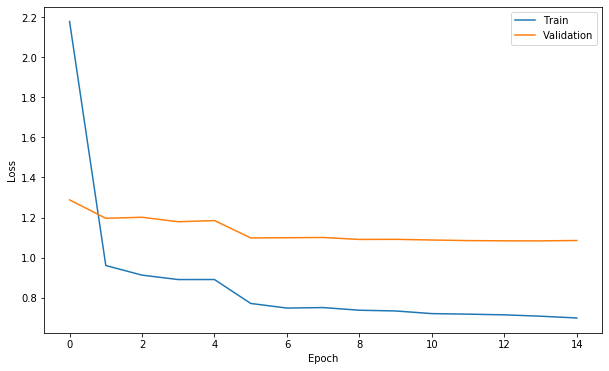

In [80]:
history = combine_histories(histories)
plot_loss(history)

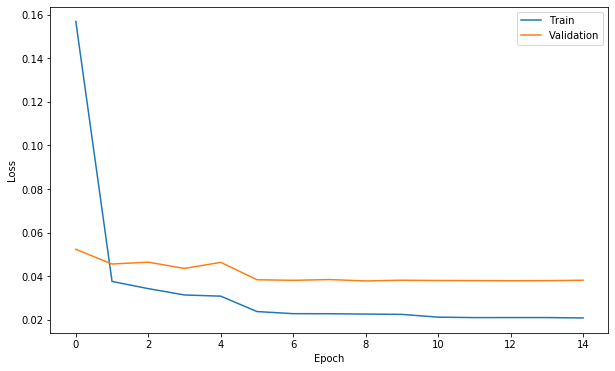

In [81]:
plot_bbox_loss(history)

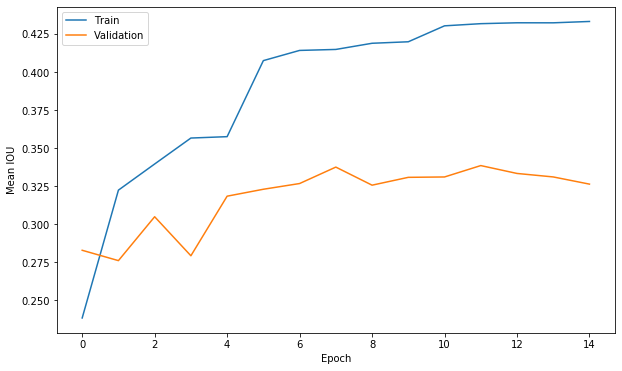

In [82]:
plot_iou(history)

## Try the model on the test set

In [83]:
def plot_prediction(row, image_dir):
    image_path = os.path.join(image_dir, row["folder"], row["image_id"] + ".jpg")
    img = image.load_img(image_path, target_size=(image_width, image_height))
    bbox_true = [row["x_min"], row["x_max"], row["y_min"], row["y_max"], row["class_name"].upper()]
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = model.predict(x)
    bbox_pred = [*pred[1][0], labels[np.argmax(pred[0])]]
    
    plot_image(img, [bbox_true, bbox_pred])
   
    print("IOU:", iou(bbox_true, bbox_pred))

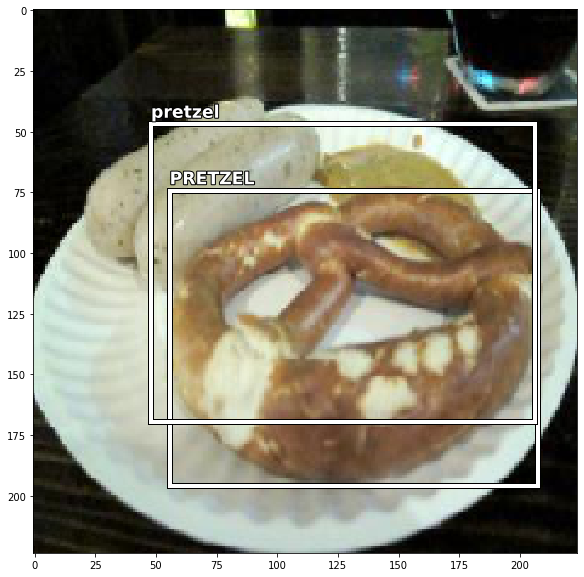

IOU: 0.6110560268328115


In [93]:
row_index = np.random.randint(len(test_annotations))
row = test_annotations.iloc[row_index]
plot_prediction(row, test_dir)